# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


### Initialize Libraries

In [1]:
import netCDF4 as nc4;        import pandas as pd
import requests;              import json;
import matplotlib as mpl;     import matplotlib.pyplot as plt
import matplotlib.tri as tri; import pathlib as pl
import cartopy.crs as ccrs;   import cartopy.io.img_tiles as cart_img
import cartopy as cart;       import cartopy.io.img_tiles as cimgt
import numpy as np;           import wse
import skill_metrics as sm;   import geopandas as gpd
import calendar;              import plotly.graph_objects as go
import seaborn as sns;
from shapely import Polygon,Point,MultiPoint,LineString,MultiLineString;import shapely.vectorized
from scipy.stats import linregress
from sklearn.metrics import root_mean_squared_error
from plotly.subplots import make_subplots
import plotly.colors as pc

salloc --ntasks=40 --nodes=1 --partition=normal --mem-per-cpu=8GB --time=06:00:00

source $HOME/miniforge3/bin/activate

### Defined Functions

#### Data for this exercise can be found here
https://doi.org/10.17603/ds2-h0fw-2p96

Download the swan_HS.63.nc from one of the 4 folders

---

### Initialize path and read netcdf file

In [2]:
root = pl.Path('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database')

#ncfile = nc4.Dataset(root / '2023' /'outputs' / 'fort.63.nc')

#### Read metadata within netcdf file

_____________________________________

In [3]:
stations = {'prudhoe':{'id':9497645,'lat':70.421459,'lon':-148.546311},
            'red':{'id':9491094,'lat':67.573681,'lon':-164.070663},
            'nome':{'id':9468756,'lat':64.499170,'lon':-165.431689},
            'unalakleet':{'id':9468333,'lat':63.881322,'lon':-160.820145},
            'paul':{'id':9464212,'lat':57.228635,'lon':-170.241801}}


In [4]:
resample_time = 'D'
years = ['2024','2023','2022','2021','2020','2019',
         '2018','2017','2016','2015','2014','2013',
         '2012','2011','2010']
name = 'nome'
#df_all, df_daily = wse.extract_model_wse_and_ice('nome', stations, years, root)
df_all = pd.read_csv(f'/scratch/tmiesse/project/model_data/{name}_model_hourly_wse_and_ice.csv')
df_all["dt"] = pd.to_datetime(df_all["dt"], errors="coerce")

# Drop rows with missing datetime or values
df_all = df_all.dropna(subset=["dt", "model_wse", "ice_conc"]).copy()
# --- Resample to Daily Values ---
df_daily = (
    df_all
    .set_index("dt")
    .resample("D")
    .agg({
        "model_wse": "max",    # Daily max WSE
        "ice_conc": "mean"     # Daily mean ice concentration
    })
    .reset_index()
)

In [4]:
df_all.to_csv(f'/scratch/tmiesse/project/model_data/{name}_model_hourly_wse_and_ice.csv')

In [5]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Fall"
# Step 2: Define season colors
season_colors = {
    "Winter": "#117733",
    "Spring": "#88CCEE",
    "Summer": "#DDCC77",
    "Fall": "#CC6677"
}


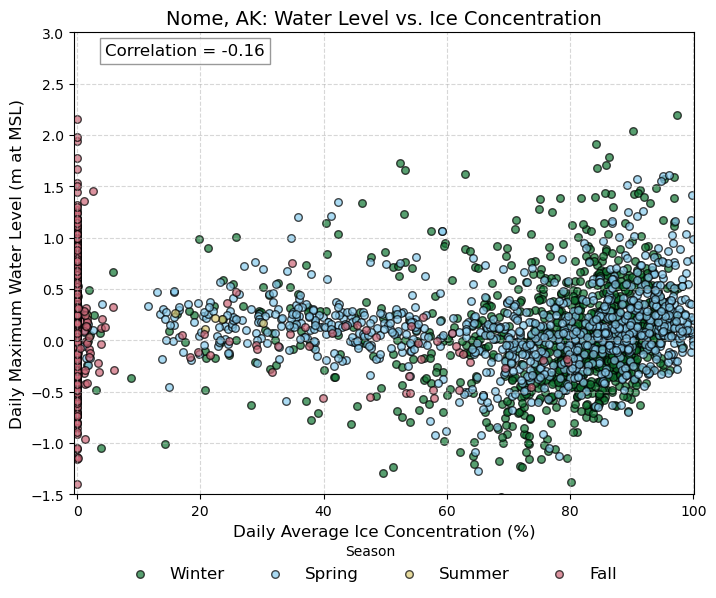

In [6]:
df_daily["month"] = df_daily["dt"].dt.month
df_daily["season"] = df_daily["month"].apply(month_to_season)

corr = df_daily["model_wse"].corr(df_daily["ice_conc"])

fig, ax = plt.subplots(figsize=(8, 6))
#ax.scatter(df_daily["ice_conc"], df_daily["model_wse"], alpha=0.7, color="steelblue", edgecolor="k")
for season in ["Winter", "Spring", "Summer", "Fall"]:
    subset = df_daily[df_daily["season"] == season]
    ax.scatter(subset["ice_conc"], subset["model_wse"], 
                label=season, color=season_colors[season],
                alpha=0.7, edgecolor="k", s=30)


ax.set_xlabel("Daily Average Ice Concentration (%)", fontsize=12)
ax.set_ylabel("Daily Maximum Water Level (m at MSL)", fontsize=12)
ax.set_ylim(-1.5,3),ax.set_xlim(-0.5,100.1)
ax.set_title(f"{name.capitalize()}, AK: Water Level vs. Ice Concentration", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.5)
ax.text(0.05, 0.95, f"Correlation = {corr:.2f}", transform=plt.gca().transAxes,
         fontsize=12, bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray"))

ax.legend(title="Season", bbox_to_anchor=(.9, -0.075), ncol=4, frameon=False, fontsize=12)
plt.savefig(f'/scratch/tmiesse/project/figures/{name}_wse_ice_cor_season.png', 
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.show()

/tmp/ipykernel_563378/1170884620.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("cool", len(years))  # Use tab20 for up to 20 distinct colors


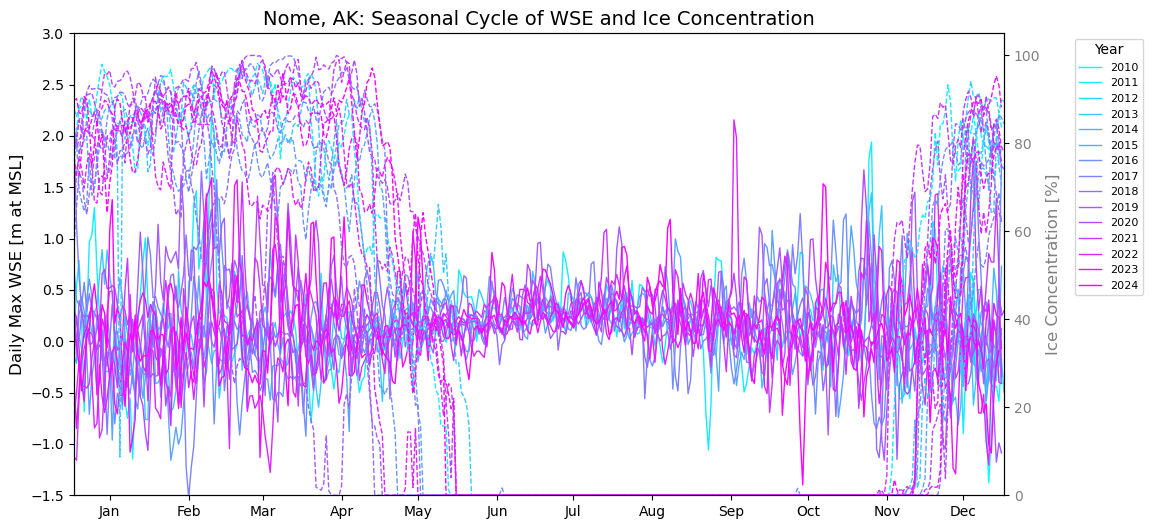

In [8]:
df_daily = df_daily.sort_values("dt")
df_daily["month_day"] = df_daily["dt"].dt.strftime("%m-%d")
df_daily["year"] = df_daily["dt"].dt.year.astype(int)
df_daily["dayofyear"] = df_daily["dt"].dt.dayofyear

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Get unique years
years = sorted(df_daily["year"].unique())
cmap = mpl.cm.get_cmap("cool", len(years))  # Use tab20 for up to 20 distinct colors
colors = {year: cmap(i) for i, year in enumerate(years)}

# --- Plot one line per year ---
for yr in years:
    df_year = df_daily[df_daily["year"] == yr]
    # Plot WSE on left y-axis
    ax1.plot(df_year["dayofyear"], df_year["model_wse"], label=f"{yr}", color=colors[yr], linewidth=1)
    ax2.plot(df_year["dayofyear"], df_year["ice_conc"], linestyle="--", color=colors[yr], linewidth=1)

# Customize axes
ax1.set_ylabel("Daily Max WSE [m at MSL]", fontsize=12)
ax1.tick_params(axis="y")

ax2.set_ylabel("Ice Concentration [%]", color="gray", fontsize=12)
ax2.tick_params(axis="y", labelcolor="gray")
ax2.set_ylim(0, 105)

# X-axis ticks as months

ax1.set_xlim(1, 366),ax1.set_ylim(-1.5, 3)
ax1.set_xticks([15, 46, 75, 106, 136, 167, 197, 228, 259, 289, 320, 350])
ax1.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                     "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

# Title and legend
ax1.set_title(f"{name.capitalize()}, AK: Seasonal Cycle of WSE and Ice Concentration", fontsize=14)
ax1.legend(title="Year", fontsize=8, loc="upper left", bbox_to_anchor=(1.07, 1.0))


# Save and show
plt.savefig(f"/scratch/tmiesse/project/figures/{name}_seasonal_wse_ice_lines.png",
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.show()

In [56]:
def categorize_ice(ice_value):
    if ice_value == 0:
        return "Open Water"
    elif ice_value <= 20:
        return "Low Ice"
    elif ice_value <= 80:
        return "Marginal Ice"
    else:
        return "Complete Ice"


def categorize_wse(wse, mhhw=0.215):
    if wse <= mhhw:
        return "Minimal WSE"
    elif wse <= 0.5:
        return "Low WSE"
    elif wse <= 1.0:
        return "Moderate WSE"
    else:
        return "Very High WSE"
    
def get_bin_color(avg_days):
    for i, upper in enumerate(bins[1:]):
        if avg_days <= upper:
            return bin_colors[i]
    return bin_colors[-1]

In [64]:
df_daily["Year"] = df_daily["dt"].dt.year
df_daily["ice_category"] = df_daily["ice_conc"].apply(categorize_ice)
df_daily["wse_category"] = df_daily["model_wse"].apply(lambda x: categorize_wse(x, mhhw=0.215))
df_year_ice = (
    df_daily
    .groupby(["Year", "ice_category"])
    .size()
    .reset_index(name="count")
)
n_years = df_daily["Year"].nunique()

# Group Ice → WSE totals across all years
df_ice_wse_all = (
    df_daily
    .groupby(["ice_category", "wse_category"])
    .size()
    .reset_index(name="total_days")
)

# ✅ Add the average column before sorting
df_ice_wse_all["avg_days_per_year"] = df_ice_wse_all["total_days"] / n_years

# ✅ Now sort
df_ice_wse_all_sorted = df_ice_wse_all.sort_values(
    by=["ice_category", "wse_category"]
).reset_index(drop=True)
# Ice Category → WSE Category
df_ice_wse_yearly = (
    df_daily
    .groupby(["Year", "ice_category", "wse_category"])
    .size()
    .reset_index(name="count")
)

cmap = mpl.cm.get_cmap("viridis")
df_ice_wse_all["avg_days_per_year"] = df_ice_wse_all["total_days"] / n_years
bins = [0, 10, 25, 50, 75, 100, 150]
bin_labels = ["0–10", "11–25", "26–50", "51–75", "76–100", "100+"]
norm = mpl.colors.Normalize(vmin=min(bins), vmax=max(bins))
bin_colors = [mpl.colors.to_hex(cmap(norm((bins[i] + bins[i+1]) / 2))) for i in range(len(bins) - 1)]


/tmp/ipykernel_563833/2794320512.py:35: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [77]:
year_labels = sorted(df_daily["Year"].astype(str).unique())
ice_labels = sorted(df_daily["ice_category"].unique())
wse_labels = sorted(df_daily["wse_category"].unique())

all_labels = year_labels + ice_labels + wse_labels
label_map = {label: i for i, label in enumerate(all_labels)}
year_colors = pc.qualitative.Set3 + pc.qualitative.Plotly
year_color_map = {year: year_colors[i % len(year_colors)] for i, year in enumerate(year_labels)}

# Build Sankey inputs
source = []
target = []
value = []
link_colors = []

# Year → Ice
for year in year_labels:
    for ice in ice_labels:
        count = df_daily[(df_daily["Year"] == int(year)) & (df_daily["ice_category"] == ice)].shape[0]
        if count > 0:
            source.append(label_map[year])
            target.append(label_map[ice])
            value.append(count*0.25)
            link_colors.append(year_color_map[year])

# Ice → WSE (aggregated, colored by bins)
scaling_factor = 2
for _, row in df_ice_wse_all_sorted.iterrows():
    ice = row["ice_category"]
    wse = row["wse_category"]
    avg_days = row["avg_days_per_year"]

    source.append(label_map[ice])
    target.append(label_map[wse])
    value.append(avg_days * scaling_factor)  # scaled for visibility
    link_colors.append(get_bin_color(avg_days))

fig = go.Figure(data=[go.Sankey(
    arrangement="perpendicular",  # ✅ this distributes links more symmetrically
    node=dict(
        pad=15,
        thickness=15,
        line=dict(color="black", width=0.5),
        label=all_labels,
        color="lightgray"
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])
for i, label in enumerate(bin_labels):
    fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(size=10, color=bin_colors[i]),
        legendgroup=label,
        showlegend=True,
        name=f"{label} Days"
    ))

fig.update_layout(
    title_text=f"{name.capitalize()} – Year → Ice Category → Max Daily WSE Category",
    font_size=11,
    height=500,
    width=750,
    margin=dict(t=100, l=50, r=50, b=50),
    xaxis=dict(visible=False),
    yaxis=dict(visible=False),
    legend=dict(
        title="Ice → WSE Link Volume",
        traceorder="normal",
        x=1.01,
        y=0.5,
        font=dict(size=10)
    )
)

fig.show()

In [32]:
name = 'nome'
df_noaa_daily = pd.read_csv(f'/scratch/tmiesse/project/noaa_data/{name}_mhhw.csv')
df_hourly_wse = pd.read_csv(f'/scratch/tmiesse/project/model_data/{name}_model_hourly_wse.csv')
df_hourly_wse["dt"] = pd.to_datetime(df_hourly_wse["dt"], errors="coerce")
df_hourly_wse["data"] = pd.to_numeric(df_hourly_wse["data"], errors="coerce")
df_hourly_wse = df_hourly_wse.dropna(subset=["dt", "data"]).copy()

# Extract the daily max WSE with exact timestamp preserved
df_model_daily = (
    df_hourly_wse
    .set_index("dt")
    .resample("D")["data"]
    .max()
    .reset_index()
)
years = ['2024','2023','2022','2021','2020','2019',
         '2018','2017','2016','2015','2014','2013',
         '2012','2011','2010']

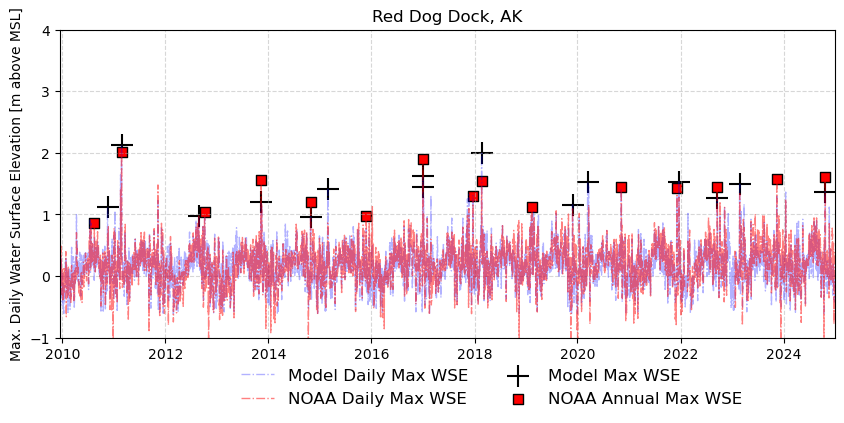

In [10]:

df_model_daily["Date"] = pd.to_datetime(df_model_daily["dt"]).dt.date  # Convert to date
df_model_daily["Date"] = pd.to_datetime(df_model_daily["Date"])  # Ensure it's in datetime64
df_model_daily = df_model_daily.sort_values(by="Date").reset_index(drop=True)
df_noaa_daily["Date"] = pd.to_datetime(df_noaa_daily["Date"]) 
df_noaa_daily["Year"] = pd.to_datetime(df_noaa_daily["Date"]).dt.year

fig, ax = plt.subplots(figsize=(10, 4))
# Plot Model Daily Max WSE
ax.plot(pd.to_datetime(df_model_daily["Date"]), df_model_daily["data"], linestyle='-.',lw=1,
        color="blue", alpha=0.3, label="Model Daily Max WSE")# if year == int(years[0]) else "")

# Plot NOAA Daily Max WSE
ax.plot(pd.to_datetime(df_noaa_daily["Date"]), df_noaa_daily["v"], linestyle='-.',lw=1,
        color="red", alpha=0.5, label="NOAA Daily Max WSE")# if year == int(years[0]) else "")

for year in years:
    # **Model Annual Max Extraction**
    idy_model = df_model_daily.loc[df_model_daily['Date'].dt.year == int(year)]
    if not idy_model.empty:
        ids_model = np.where(df_model_daily['data'].values == np.max(df_model_daily['data'][idy_model.index]))[0]
        ax.scatter(df_model_daily["Date"][ids_model], df_model_daily["data"][ids_model], 
                   color="k", marker="+", s=250, label="Model Max WSE" if year == years[0] else "")

    # **NOAA Annual Max Extraction**
    idy_noaa = df_noaa_daily.loc[df_noaa_daily['Date'].dt.year == int(year)]
    if not idy_noaa.empty:
        ids_noaa = np.where(df_noaa_daily['v'].values == np.max(df_noaa_daily['v'][idy_noaa.index]))[0]
        ax.scatter(df_noaa_daily["Date"][ids_noaa], df_noaa_daily["v"][ids_noaa], 
                   color="red", marker="s", s=50, label="NOAA Annual Max WSE" if year == years[0] else "", edgecolors="black")

ax.set_ylabel("Max. Daily Water Surface Elevation [m above MSL]")
ax.set_ylim([-1,4])
ax.set_xlim([pd.to_datetime(df_model_daily["Date"].min()), pd.to_datetime(df_model_daily["Date"].max())])
ax.set_title(f"{name.capitalize()} Dog Dock, AK")#{name.capitalize()},
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend(loc='upper right', bbox_to_anchor=(.9, -0.05), ncol=2, frameon=False, fontsize=12)
plt.savefig(f'/scratch/tmiesse/project/figures/{name}_daily_max_model_vs_noaa_scatter.png', 
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)

plt.show()

In [22]:
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions - targets)**2))

In [17]:
df_noaa = df_noaa_daily.copy()
df_noaa["t"] = pd.to_datetime(df_noaa["Date"])
df_noaa["Date"] = pd.to_datetime(df_noaa["Date"], errors="coerce")
df_noaa["v"] = pd.to_numeric(df_noaa["v"], errors="coerce")
df_noaa_clean = df_noaa.dropna(subset=["t", "v"]).copy()
df_noaa_clean["date"] = df_noaa_clean["t"].dt.date

daily_max_values = df_noaa_clean.groupby("date")["v"].max().reset_index()
daily_max_values.rename(columns={"v": "NOAA Max WSE"}, inplace=True)
df_noaa = df_noaa_daily.copy()
df_noaa["t"] = pd.to_datetime(df_noaa["Date"])
df_noaa["v"] = pd.to_numeric(df_noaa["v"], errors="coerce")
df_noaa = df_noaa.dropna(subset=["v"])

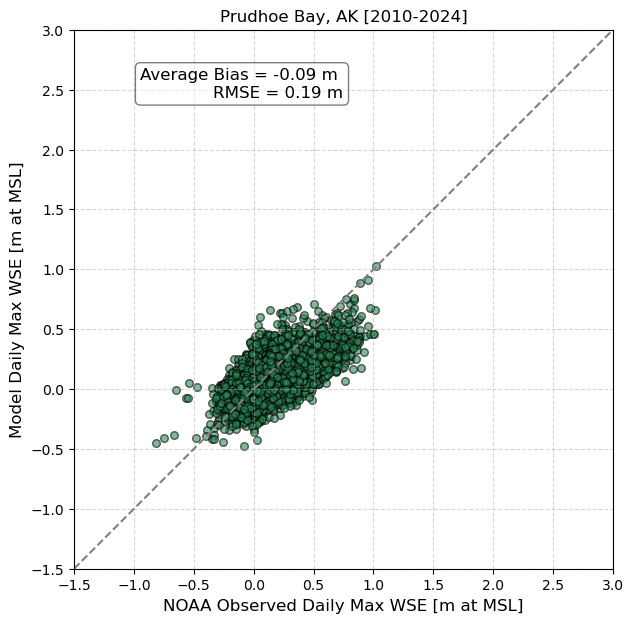

In [18]:
df_noaa["Date"] = pd.to_datetime(df_noaa["Date"], errors="coerce")
df_noaa_daily_exact = (
    df_noaa
    .groupby(df_noaa["Date"].dt.date)
    .apply(lambda x: x.loc[x["v"].idxmax()])
    .reset_index(drop=True)
    .rename(columns={"Date": "dt", "v": "NOAA Max WSE"})
)

# Model: same idea — max per day with exact datetime preserved
#df_model_daily["dt"] = pd.to_datetime(df_model_daily["dt"], errors="coerce")
#df_model_daily["data"] = pd.to_numeric(df_model_daily["data"], errors="coerce")

# Drop rows where model WSE is missing
df_model_daily_clean = df_model_daily.dropna(subset=["dt", "data"]).copy()

# Now safely extract the daily max values with exact timestamps
df_model_daily_exact = (
    df_model_daily_clean
    .groupby(df_model_daily_clean["dt"].dt.date)
    .apply(lambda x: x.loc[x["data"].idxmax()])
    .reset_index(drop=True)
)
df_model_daily_exact["dt"] = pd.to_datetime(df_model_daily_exact["dt"], utc=True)
df_noaa_daily_exact["dt"] = pd.to_datetime(df_noaa_daily_exact["dt"], utc=True)
# Step 2: Merge on exact matching UTC datetimes
df_compare_exact = pd.merge(df_model_daily, df_noaa_daily_exact, on="dt", how="inner").dropna()
# --- Step 4: Create scatter plot with 1:1 line only ---
fig, ax = plt.subplots(figsize=(7, 7))

# steelblue nome
# darkorange red dog
# seagreen prudhoe 
# mediumorchid unalakleet

# Scatter plot
color = "seagreen"
ax.scatter(df_compare_exact["NOAA Max WSE"], df_compare_exact["data"],
           color=color, edgecolor="k", alpha=0.6, s=30) 
rmse_val = rmse(df_compare_exact["NOAA Max WSE"], df_compare_exact["data"])
mbias = np.mean(df_compare_exact["data"]-df_compare_exact["NOAA Max WSE"])
text = (f'Average Bias = {mbias:.2f} m \n'
        f'RMSE = {rmse_val:.2f} m')
bbox = dict(boxstyle='round', fc='white', ec='black', alpha=0.5)
ax.text(0.5,0.875,text,fontsize=12,transform=ax.transAxes, horizontalalignment='right',bbox=bbox)

lims = [-1.5, 3]
ax.plot(lims, lims, linestyle="--", color="gray")

# Labels and formatting
ax.set_xlabel("NOAA Observed Daily Max WSE [m at MSL]",fontsize=12)
ax.set_ylabel("Model Daily Max WSE [m at MSL]",fontsize=12)
ax.set_title(f"{name.capitalize()} Bay, AK [2010-2024]")
ax.set_xlim(lims),ax.set_ylim(lims)
ax.set_aspect('equal'),ax.grid(True, linestyle="--", alpha=0.5)
#plt.savefig(f'/scratch/tmiesse/project/figures/{name}_scatter2.png', 
#            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.show()

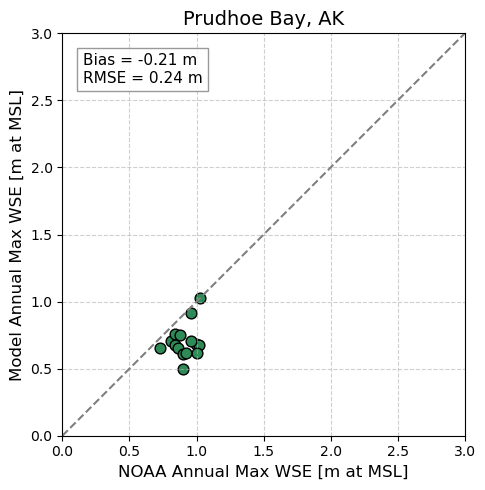

In [19]:
df_model_daily["Year"] = df_model_daily["dt"].dt.year
df_noaa_daily["Year"] = pd.to_datetime(df_noaa_daily["Date"]).dt.year
model_year_counts = df_model_daily["dt"].dt.date.groupby(df_model_daily["Year"]).nunique()
valid_model_years = model_year_counts[model_year_counts >= 364].index.tolist()

# Keep only complete years in model data
df_model_daily = df_model_daily[df_model_daily["Year"].isin(valid_model_years)]

# Optional: log dropped years
all_model_years = df_model_daily["Year"].unique()
excluded_years = set(model_year_counts.index) - set(valid_model_years)

model_annual_max = df_model_daily.groupby("Year")["data"].max().reset_index()
model_annual_max.rename(columns={"data": "Model Max WSE"}, inplace=True)

noaa_annual_max = df_noaa_daily.groupby("Year")["v"].max().reset_index()
noaa_annual_max.rename(columns={"v": "NOAA Max WSE"}, inplace=True)

# --- Step 4: Keep only years present in both datasets ---
common_years = sorted(set(model_annual_max["Year"]).intersection(noaa_annual_max["Year"]))
model_annual_max = model_annual_max[model_annual_max["Year"].isin(common_years)]
noaa_annual_max = noaa_annual_max[noaa_annual_max["Year"].isin(common_years)]

# --- Step 5: Merge the two datasets ---
df_annual_compare = pd.merge(model_annual_max, noaa_annual_max, on="Year", how="inner")


# --- Step 4: Optional error metrics ---
rmse_val = rmse(df_annual_compare["NOAA Max WSE"], df_annual_compare["Model Max WSE"])
bias_val = (df_annual_compare["Model Max WSE"] - df_annual_compare["NOAA Max WSE"]).mean()

# --- Step 5: Scatter Plot ---
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(df_annual_compare["NOAA Max WSE"], df_annual_compare["Model Max WSE"],
           color=color, edgecolor="black", s=60)

# 1:1 line
lims = [0,3]
ax.plot(lims, lims, linestyle="--", color="gray")

# Labels and stats
ax.set_xlabel("NOAA Annual Max WSE [m at MSL]", fontsize=12)
ax.set_ylabel("Model Annual Max WSE [m at MSL]", fontsize=12)
ax.set_title(f"{name.capitalize()} Bay, AK", fontsize=14)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect("equal")
ax.grid(True, linestyle="--", alpha=0.6)

# Annotate metrics
ax.text(0.05, 0.95,
        f"Bias = {bias_val:.2f} m\nRMSE = {rmse_val:.2f} m",
        transform=ax.transAxes, fontsize=11,
        bbox=dict(facecolor="white", edgecolor="gray", alpha=0.8),
        verticalalignment="top")

plt.tight_layout()
plt.savefig(f"/scratch/tmiesse/project/figures/{name}_annual_max_scatter.png", 
            dpi=480, bbox_inches="tight", pad_inches=0.1, transparent=False)
plt.show()

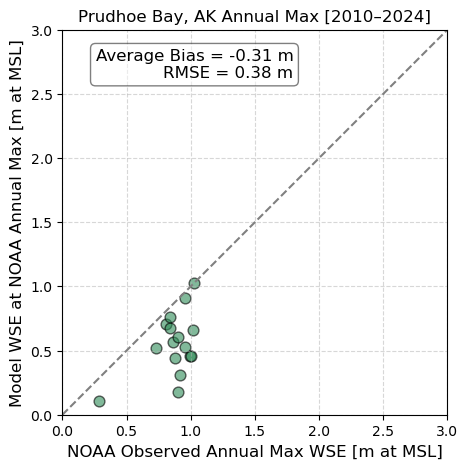

In [20]:
df_noaa_annual = df_compare_exact.loc[
    df_compare_exact.groupby(df_compare_exact["dt"].dt.year)["NOAA Max WSE"].idxmax()
].copy()

# Step 2: Extract matching model value at the same datetime (already present in df_compare_exact)
# This step is already implicitly done since df_compare_exact holds model and NOAA at same timestamp
# So we already have NOAA annual max AND corresponding model value

# Step 3: Plot the result
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(df_noaa_annual["NOAA Max WSE"], df_noaa_annual["data"],
           color=color, edgecolor="k", alpha=0.6, s=60)

# Error metrics
rmse_val = rmse(df_noaa_annual["NOAA Max WSE"], df_noaa_annual["data"])
mbias = (df_noaa_annual["data"] - df_noaa_annual["NOAA Max WSE"]).mean()

text = f"Average Bias = {mbias:.2f} m\nRMSE = {rmse_val:.2f} m"
bbox = dict(boxstyle='round', fc='white', ec='black', alpha=0.5)

ax.text(0.6, 0.875, text, fontsize=12, transform=ax.transAxes,
        horizontalalignment='right', bbox=bbox)

# 1:1 reference line
lims = [0, 3]
ax.plot(lims, lims, linestyle="--", color="gray")

# Labels and formatting
ax.set_xlabel("NOAA Observed Annual Max WSE [m at MSL]", fontsize=12)
ax.set_ylabel("Model WSE at NOAA Annual Max [m at MSL]", fontsize=12)
ax.set_title(f"{name.capitalize()} Bay, AK Annual Max [2010–2024]")
ax.set_xlim(lims), ax.set_ylim(lims)
ax.set_aspect('equal'), ax.grid(True, linestyle="--", alpha=0.5)

# Save and show
plt.savefig(f'/scratch/tmiesse/project/figures/{name}_annual_max_aligned_scatter.png',
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.show()

In [33]:
df_model_daily["Year"] = pd.to_datetime(df_model_daily["dt"]).dt.year
df_noaa_daily["Year"] = pd.to_datetime(df_noaa_daily["Date"]).dt.year
df_model_percentiles = (
    df_model_daily.groupby("Year")["data"]
    .quantile([0.95, 0.99])
    .unstack()
    .reset_index()
    .rename(columns={0.95: "Model 95th", 0.99: "Model 99th"})
)

# NOAA percentiles
df_noaa_percentiles = (
    df_noaa_daily.groupby("Year")["v"]
    .quantile([0.95, 0.99])
    .unstack()
    .reset_index()
    .rename(columns={0.95: "NOAA 95th", 0.99: "NOAA 99th"})
)
df_compare_percentiles = pd.merge(
    df_model_percentiles,
    df_noaa_percentiles,
    on="Year",
    how="inner"
)

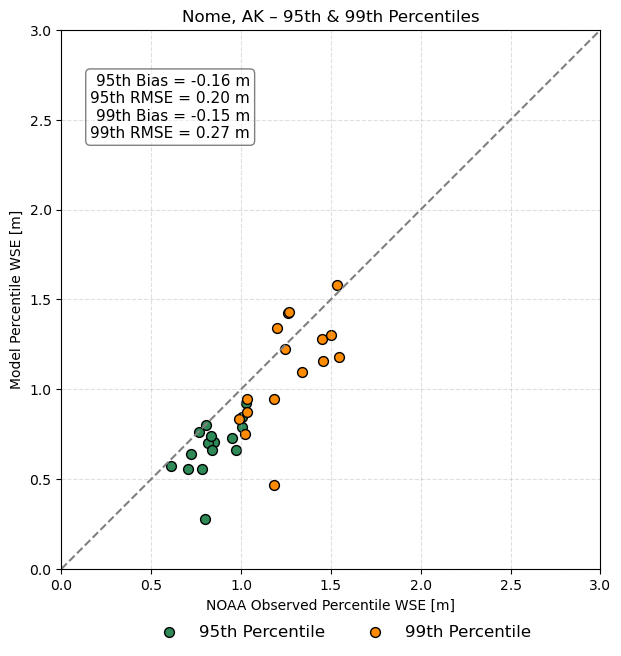

In [35]:

fig, ax = plt.subplots(figsize=(7, 7))

# Scatter for 95th
ax.scatter(df_compare_percentiles["NOAA 95th"], df_compare_percentiles["Model 95th"],
           label="95th Percentile", color="seagreen", edgecolor="k", s=50)

# Scatter for 99th
ax.scatter(df_compare_percentiles["NOAA 99th"], df_compare_percentiles["Model 99th"],
           label="99th Percentile", color="darkorange", edgecolor="k", s=50)

# 1:1 line
lims = [0, 3]
ax.plot(lims, lims, "--", color="gray")
rmse_95 = rmse(df_compare_percentiles["Model 95th"], df_compare_percentiles["NOAA 95th"])
bias_95 = np.mean(df_compare_percentiles["Model 95th"] - df_compare_percentiles["NOAA 95th"])

# 99th Percentile Comparison
rmse_99 = rmse(df_compare_percentiles["Model 99th"], df_compare_percentiles["NOAA 99th"])
bias_99 = np.mean(df_compare_percentiles["Model 99th"] - df_compare_percentiles["NOAA 99th"])
text = (
    f"95th Bias = {bias_95:.2f} m\n"
    f"95th RMSE = {rmse_95:.2f} m\n"
    f"99th Bias = {bias_99:.2f} m\n"
    f"99th RMSE = {rmse_99:.2f} m"
)

bbox = dict(boxstyle="round", fc="white", ec="black", alpha=0.5)
ax.text(0.35, 0.8, text, transform=ax.transAxes,
        fontsize=11, ha="right", bbox=bbox)
# Labels and styling
ax.set_xlabel("NOAA Observed Percentile WSE [m]")
ax.set_ylabel("Model Percentile WSE [m]")
ax.set_title(f"{name.capitalize()}, AK – 95th & 99th Percentiles")
ax.set_xlim(lims), ax.set_ylim(lims)
ax.set_aspect("equal"), ax.grid(True, linestyle="--", alpha=0.4)
ax.legend(loc='upper right', bbox_to_anchor=(.9, -0.075), ncol=2, frameon=False, fontsize=12)
plt.savefig(f'/scratch/tmiesse/project/figures/{name}_percentile_scatter.png',
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.show()

In [18]:

# Merge NOAA and Model Annual Maximums
df_comparison = pd.merge(df_annual_max, df_noaa_max, on="Year", how="inner")

# Compute Trend Lines
slope_model, intercept_model, _, _, _ = linregress(df_comparison["Year"], df_comparison["data"])
slope_noaa, intercept_noaa, _, _, _ = linregress(df_comparison["Year"], df_comparison["NOAA Max WSE"])

df_comparison["Model Trend"] = df_comparison["Year"] * slope_model + intercept_model
df_comparison["NOAA Trend"] = df_comparison["Year"] * slope_noaa + intercept_noaa

NameError: name 'df_noaa_max' is not defined

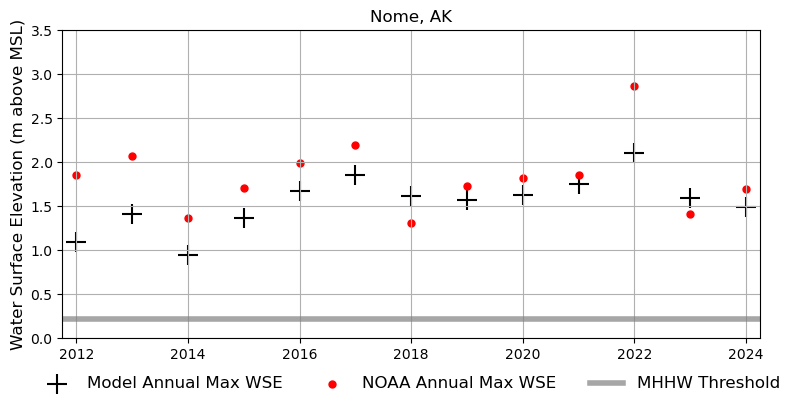

In [10]:
thresh = 0.215
fig, ax = plt.subplots(figsize=(9, 4))
scatter_model = ax.scatter(df_annual_max["Year"], df_annual_max["data"]*1, 
                           color="k", marker="+", s=200, label="Model Annual Max WSE")

# Scatter Plot for NOAA Annual Maximums
scatter_noaa = ax.scatter(df_noaa_max["Year"], df_noaa_max["NOAA Max WSE"], 
                          color="red", marker=".", s=100, label="NOAA Annual Max WSE")



# MHHW Threshold Line
ax.axhline(thresh, linestyle="-", linewidth=4, color='grey', alpha=0.7, label="MHHW Threshold")


ax.grid(True)
ax.set_ylabel("Water Surface Elevation (m above MSL)",fontsize=12)
ax.set_title(f"{name.capitalize()}, AK")#{name.capitalize()},
ax.set_xlim([2011.75, 2024.25])
ax.set_ylim([0,3.5])
#ax.legend(loc='upper left', frameon=False, fontsize=10)
ax.legend(loc='upper right', bbox_to_anchor=(1.05, -0.075), ncol=3, frameon=False, fontsize=12)
# Save and show plot
plt.savefig(f'/scratch/tmiesse/project/figures/{name}_annual_obs.png', 
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.show()


In [15]:
#**Define Seasons**
seasons = {
    "Winter": [12, 1, 2],
    "Spring": [3, 4, 5],
    "Summer": [6, 7, 8],
    "Fall": [9, 10, 11]
}

# **Assign Colors to Months**
colors = ['#8E86B5','#117733','#44AA99','#88CCEE',
          '#DDCC77','#CC6677','#AA4499','#C5779E',
          '#448FAA','#DDA377','#18B56E','#BDF356']

season_colors = {
    "Winter": {12: colors[0], 1: colors[1], 2: colors[2]},
    "Spring": {3: colors[3], 4: colors[4], 5: colors[5]},
    "Summer": {6: colors[6], 7: colors[7], 8: colors[8]},
    "Fall": {9: colors[9], 10: colors[10], 11: colors[11]}
}


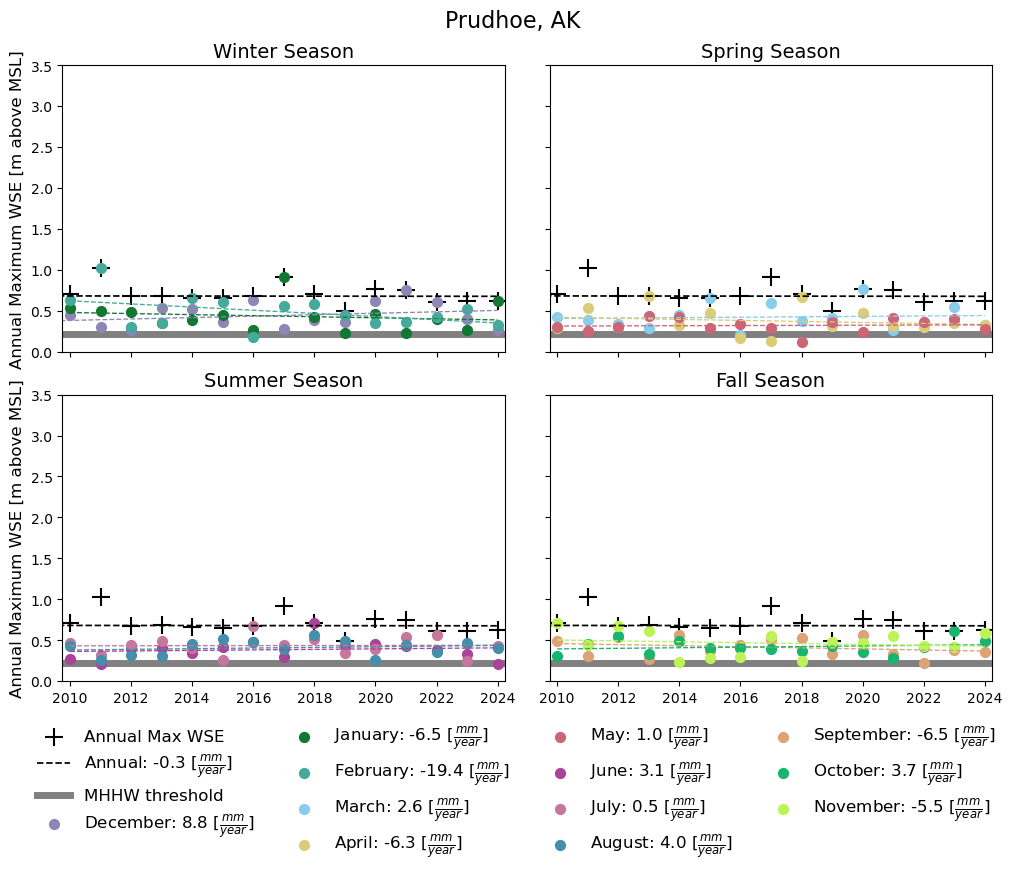

In [17]:

df_monthly_max = df_daily_wse.groupby(["Year", "Month"])["data"].max().reset_index()
slope_annual, intercept_annual, _, _, _ = linregress(df_annual_max["Year"], df_annual_max["data"])
df_annual_max["Expected_WSE"] = df_annual_max["Year"] * slope_annual + intercept_annual

thresh = 0.215
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten() 
plt.subplots_adjust(wspace=0.1, hspace=0.15)
legend_handles = {}
for idx, (season, months) in enumerate(seasons.items()):
    ax = axs[idx]
    threshold = ax.axhline(thresh, linestyle="-", linewidth=5,color='grey',label='MHHW threshold',zorder=0)
    scatter_annual=ax.scatter(df_annual_max["Year"], df_annual_max["data"], label="Annual Max WSE", color="k", s=150,marker='+')
    trend_annual,=ax.plot(df_annual_max["Year"], df_annual_max["Expected_WSE"], color="k", linestyle="--",linewidth=1.25,
            label=f"Annual: {slope_annual*1000:.1f} "+r'$[\frac{mm}{year}]$')

    if "Annual Max WSE" not in legend_handles:
        legend_handles["Annual Max WSE"] = scatter_annual
    if "Annual Trend" not in legend_handles:
        legend_handles["Annual Trend"] = trend_annual
    if "MHHW threshold" not in legend_handles:
        legend_handles["MHHW threshold"] = threshold

    for month in months:
        df_month = df_monthly_max[df_monthly_max["Month"] == month]
        if len(df_month) > 1:  # Ensure enough data points for regression
            slope_month, intercept_month, _, _, _ = linregress(df_month["Year"], df_month["data"])
            scatter_month = ax.scatter(df_month["Year"], df_month["data"], color=season_colors[season][month], s=50,
                                       label=f"{calendar.month_name[month]}: {slope_month*1000:.1f} "+r'$[\frac{mm}{year}]$')
            trend_month, =ax.plot(df_month["Year"], df_month["Year"] * slope_month + intercept_month,
                    linestyle="--", color=season_colors[season][month], linewidth=0.95,label=f"{calendar.month_name[month]}")#: {slope_month*1000:.1f} "+r'$[\frac{mm}{year}]$')
            if calendar.month_name[month] not in legend_handles:
                legend_handles[calendar.month_name[month]] = scatter_month

    ax.set_ylim([-0.0001, 3.500001])
    if idx in [0, 2]:  # Winter and Summer (left-side subplots)
        ax.set_ylabel("Annual Maximum WSE [m above MSL]", fontsize=12)
    else:  # Remove y-axis labels from right-side plots
        ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xlim([2009.75, 2024.25])
    ax.set_title(f"{season} Season", fontsize=14)
    #ax.grid(True)
fig.legend(handles=legend_handles.values(), loc='upper right', bbox_to_anchor=(0.915, 0.075), ncol=4, frameon=False, fontsize=12)
fig.suptitle(f"{name.capitalize()}, AK", fontsize=16,x=0.5,y=0.95)#

plt.savefig(f'/scratch/tmiesse/project/figures/{name}_season_trendv2.png',dpi=480,bbox_inches='tight',pad_inches=0.1,transparent=True)
plt.show()

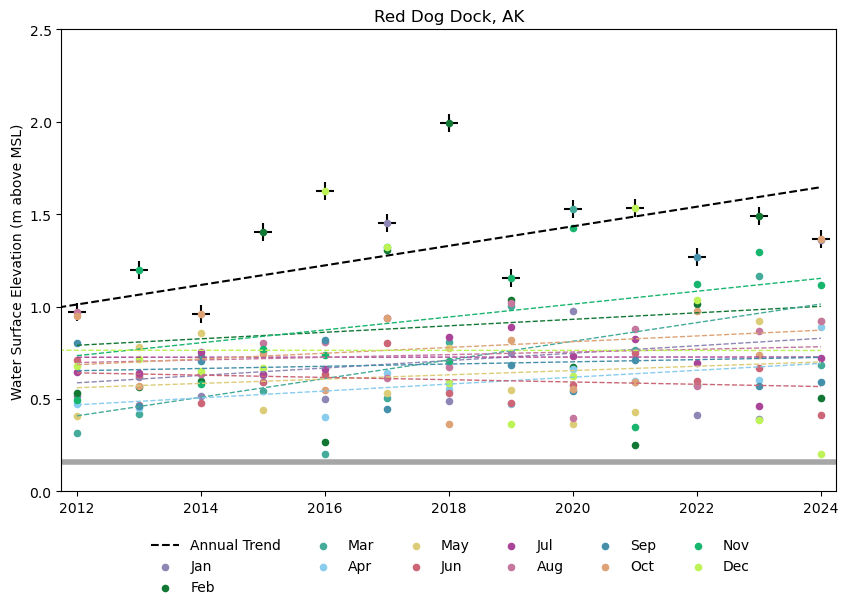

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Annual Max WSE
scatter_annual = ax.scatter(df_annual_max["Year"], df_annual_max["data"], 
                            color="black", marker="+", s=150, label="Annual Max WSE")

# Annual Trend Line
annual_trend, = ax.plot(df_annual_max["Year"], df_annual_max["Expected_WSE"], 
        linestyle="--", color="black", linewidth=1.5, label="Annual Trend")

legend_handles = {"Annual Trend": annual_trend}
# Loop Through Each Month and Plot Monthly Max Data
for month in range(1, 13):
    df_monthly = df_monthly_max[df_monthly_max["Month"] == month]
    
    if len(df_monthly) > 1:  # Ensure enough data points for trend calculation
        # Compute Monthly Trend
        slope_month, intercept_month, _, _, _ = linregress(df_monthly["Year"], df_monthly["data"])
        df_monthly["Expected_WSE"] = df_monthly["Year"] * slope_month + intercept_month
        
        # Scatter plot for Monthly Max WSE
        scatter =ax.scatter(df_monthly["Year"], df_monthly["data"], 
                   color=colors[month - 1], marker='o', s=20, label=f"{calendar.month_abbr[month]} Max WSE")
        legend_handles[f"{calendar.month_abbr[month]}"] = scatter
        # Monthly Trend Line
        ax.plot(df_monthly["Year"], df_monthly["Expected_WSE"], 
                linestyle="--", color=colors[month - 1], linewidth=1, 
                label=f"{calendar.month_abbr[month]} Trend")

# MHHW Threshold Line
ax.axhline(thresh, linestyle="-", linewidth=4, color='grey', alpha=0.7, label="MHHW Threshold")

# Labels and Formatting

ax.set_ylabel("Water Surface Elevation (m above MSL)")
ax.set_title(f"{name.capitalize()} Dog Dock, AK")
ax.set_xlim([2011.75, 2024.25])
ax.set_ylim([0, 2.5])
ax.legend(handles=legend_handles.values(),bbox_to_anchor=(.1, -0.075), labels=legend_handles.keys(), 
          loc="upper left", frameon=False, fontsize=10, ncol=6)
#fig.legend(handles=legend_handles.values(), loc='upper right', , ncol=4, frameon=False, fontsize=10)
# Save and Show Plot
plt.savefig(f'/scratch/tmiesse/project/figures/{name}_monthly_vs_annual_trend.png', 
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.show()

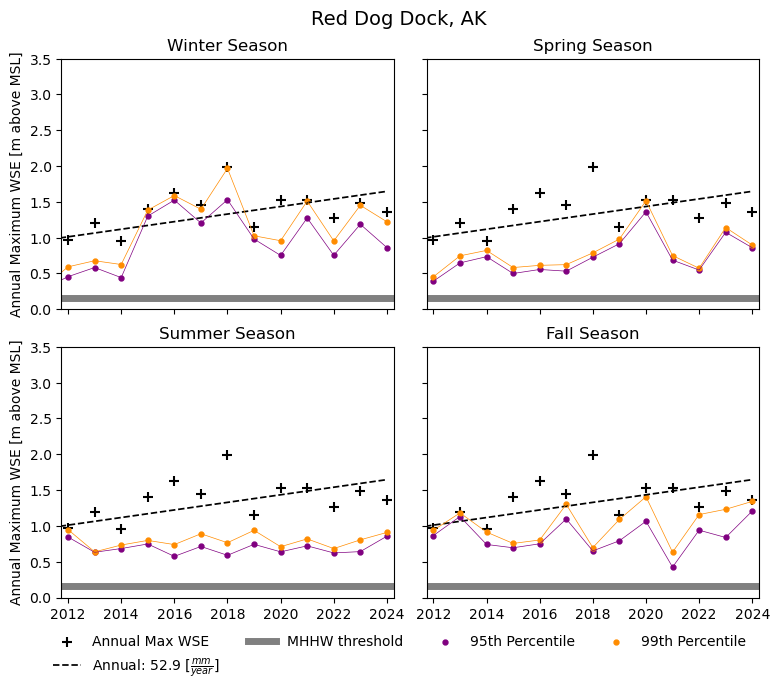

In [25]:

df_monthly_max = df_daily_wse.groupby(["Year", "Month"])["data"].max().reset_index()
slope_annual, intercept_annual, _, _, _ = linregress(df_annual_max["Year"], df_annual_max["data"])
df_annual_max["Expected_WSE"] = df_annual_max["Year"] * slope_annual + intercept_annual
df_percentiles = df_daily_wse.groupby(["Year", "Month"])["data"].quantile([0.95, 0.99]).unstack().reset_index()
df_percentiles.columns = ["Year", "Month", "95th Percentile", "99th Percentile"]

df_seasonal_max = pd.DataFrame()
for season, months in seasons.items():
    df_season = df_percentiles[df_percentiles["Month"].isin(months)]
    df_season_max = df_season.groupby("Year")[["95th Percentile", "99th Percentile"]].max().reset_index()
    df_season_max["Season"] = season
    df_seasonal_max = pd.concat([df_seasonal_max, df_season_max])

#thresh = 0.215
fig, axs = plt.subplots(2, 2, figsize=(9, 7), sharex=True, sharey=True)
axs = axs.flatten()  # Flatten into a 1D array for easier access
plt.subplots_adjust(wspace=0.1, hspace=0.15)
legend_handles = {}
for idx, (season, months) in enumerate(seasons.items()):
    ax = axs[idx]
    df_season_max = df_seasonal_max[df_seasonal_max["Season"] == season]
    df_season_annual = df_annual_max[df_annual_max["Year"].isin(df_season_max["Year"])]


    threshold = ax.axhline(thresh, linestyle="-", linewidth=5,color='grey',label='MHHW threshold')
    scatter_annual=ax.scatter(df_annual_max["Year"], df_annual_max["data"], label="Annual Max WSE", color="k", s=50,marker='+')
    trend_annual,=ax.plot(df_annual_max["Year"], df_annual_max["Expected_WSE"], color="k", linestyle="--",linewidth=1.25,
            label=f"Annual: {slope_annual*1000:.1f} "+r'$[\frac{mm}{year}]$')
    p95_scatter = ax.scatter(df_season_max["Year"], df_season_max["95th Percentile"],
                             color="purple",marker='.', s=50, label="95th Percentile")
    ax.plot(df_season_max["Year"], df_season_max["95th Percentile"],
                             color="purple",lw=0.5)
    p99_scatter = ax.scatter(df_season_max["Year"], df_season_max["99th Percentile"],
                             color="darkorange",marker='.', s=50, label="99th Percentile")
    ax.plot(df_season_max["Year"], df_season_max["99th Percentile"],
                             color="darkorange",lw=0.5)

    if "Annual Max WSE" not in legend_handles:
        legend_handles["Annual Max WSE"] = scatter_annual
    if "Annual Trend" not in legend_handles:
        legend_handles["Annual Trend"] = trend_annual
    if "MHHW threshold" not in legend_handles:
        legend_handles["MHHW threshold"] = threshold

    if "95th Percentile" not in legend_handles:
        legend_handles["95th Percentile"] = p95_scatter
    if "99th Percentile" not in legend_handles:
        legend_handles["99th Percentile"] = p99_scatter

    ax.set_ylim([-0.0001, 3.500001])
    if idx in [0, 2]:  # Winter and Summer (left-side subplots)
        ax.set_ylabel("Annual Maximum WSE [m above MSL]")
    else:  # Remove y-axis labels from right-side plots
        ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xlim([2011.75, 2024.25])
    ax.set_title(f"{season} Season")
    #ax.grid(True)
fig.legend(handles=legend_handles.values(), loc='upper right', bbox_to_anchor=(.9, 0.075), ncol=4, frameon=False, fontsize=10)
fig.suptitle(f"{name.capitalize()} Dog Dock, AK", fontsize=14,x=0.5,y=0.95)#{name.capitalize()},

plt.savefig(f'/scratch/tmiesse/project/figures/{name}_seasonal_percentiles.png',dpi=480,bbox_inches='tight',pad_inches=0.1,transparent=True)
plt.show()

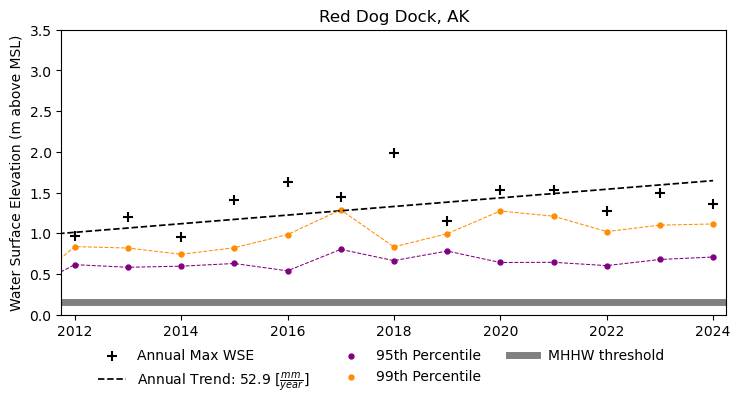

In [26]:
# Compute Annual 95th and 99th Percentiles Directly from Hourly WSE Data
df_annual_percentiles = df_list  # This contains hourly WSE data from all years

# Concatenate hourly data for all years before computing percentiles
df_hourly_wse = pd.concat(df_annual_percentiles, ignore_index=True)

# Compute annual percentiles directly from hourly data
df_annual_percentiles = df_hourly_wse.groupby("Year")["data"].quantile([0.95, 0.99]).unstack().reset_index()
df_annual_percentiles.columns = ["Year", "95th Percentile", "99th Percentile"]
# **Annual Trend Plot with 95th and 99th Percentiles**
fig = plt.figure(figsize=(7,3))

ax = plt.axes([0,0.,0.95,.95])

# Scatter plot for Annual Max WSE
scatter_annual = ax.scatter(df_annual_max["Year"], df_annual_max["data"], 
                            label="Annual Max WSE", color="k", s=50, marker='+')

# Trend line for Annual Max WSE
ax.plot(df_annual_max["Year"], df_annual_max["Expected_WSE"], 
        color="k", linestyle="--", linewidth=1.25, 
        label=f"Annual Trend: {slope_annual*1000:.1f} "+r'$[\frac{mm}{year}]$')

# Scatter and trend for Annual 95th Percentile
scatter_95 = ax.scatter(df_annual_percentiles["Year"], df_annual_percentiles["95th Percentile"], 
                         color="purple", marker='.', s=50, label="95th Percentile")
ax.plot(df_annual_percentiles["Year"], df_annual_percentiles["95th Percentile"], 
        color="purple", lw=0.75, linestyle="--")

# Scatter and trend for Annual 99th Percentile
scatter_99 = ax.scatter(df_annual_percentiles["Year"], df_annual_percentiles["99th Percentile"], 
                         color="darkorange", marker='.', s=50, label="99th Percentile")
ax.plot(df_annual_percentiles["Year"], df_annual_percentiles["99th Percentile"], 
        color="darkorange", lw=0.75, linestyle="--")

# MHHW threshold line
ax.axhline(thresh, linestyle="-", linewidth=5, color='grey', label='MHHW threshold')

# Labels and formatting

ax.set_ylabel("Water Surface Elevation (m above MSL)")
ax.set_title(f"{name.capitalize()} Dog Dock, AK")#{name.capitalize()},
ax.set_xlim([2011.75, 2024.25])
ax.set_ylim([0,3.5])
#ax.legend(loc='upper left', frameon=False, fontsize=10)
ax.legend(loc='upper right', bbox_to_anchor=(0.925, -0.075), ncol=3, frameon=False, fontsize=10)
# Save and show plot
plt.savefig(f'/scratch/tmiesse/project/figures/{name}_annual_trend.png', 
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.show()


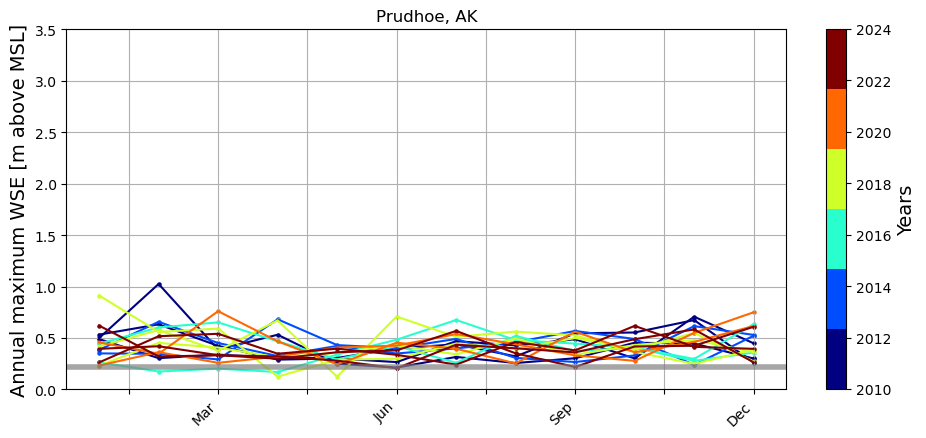

In [19]:
# plot parameters to initialize the plot
#plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(8,4))

ax = plt.axes([0,0.,0.9,.9])
c=0
num_classes = 6#int(len(df_annual_max["Year"].unique())/2)
cmap = mpl.cm.get_cmap("jet", num_classes)

# Normalize the color scale to the range of years
norm = mpl.colors.Normalize(vmin=2010, vmax=max(df_annual_max["Year"]))

df_monthly_mean = df_daily_wse.groupby(["Year", "Month"])["data"].max().reset_index()
monthly_trends = {}
for year in df_monthly_mean["Year"].unique():
    df_year = df_monthly_mean[df_monthly_mean["Year"] == year]
    
    # Compute trend for the month
    slope_month, intercept_month, r_value, p_value, std_err = linregress(df_month["Year"], df_month["data"])
    monthly_trends[month] = {"Slope": slope_month, "R²": r_value**2, "p-value": p_value}
    colors = cmap(norm(year))
    sc = ax.scatter(df_year["Month"], df_year["data"],color=colors,s=5)
    ax.plot(df_year["Month"], df_year["data"],color=colors)

    c+=1
cbar_ax = fig.add_axes([.95,0.001,0.025,0.90])
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,norm=norm,orientation='vertical')
cbar.set_label(label = r'Years',fontsize =14)
ax.axhline(thresh, linestyle="-", linewidth=4, color='grey', alpha=0.7, label="MHHW Threshold")
ax.set_ylabel(r'Annual maximum WSE [m above MSL]',fontsize=14)
ax.set_ylim([-0.0001,3.50001])

ax.grid(True)
#ax.legend(loc='upper right', bbox_to_anchor=(1.15, .975),ncol=1,frameon=False,fontsize=8)
ax.set_title(f"{name.capitalize()}, AK")
month_names = [calendar.month_name[i] for i in range(1,13)]
ax.set_xticks(range(1, 13))
ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=45, horizontalalignment='right')
plt.savefig(f'/scratch/tmiesse/project/figures/{name}_monthly_wl_trend.png',dpi=480,bbox_inches='tight',pad_inches=0.1,transparent=True)
plt.show()